In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
import torchvision
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
from random import randint

In [4]:
epochs = 15
batch_size = 64# num_workers = 2   # num_workers
latent_code = 32   


image_size = int(64 * 64 * 3)
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

data_path = '../anime-faces/data/'
transform = transforms.Compose(
    [
        transforms.Resize((64,64)), # resize images to same size
        torchvision.transforms.ToTensor(), # image to tensor
        transforms.Normalize(mean, std)
    ]
)

# dataset
dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transform
)

# train test split
num_data = len(dataset)
ratio = .9
# print(num_data)
# print(int(num_data*0.8), num_data-int(num_data*0.8))
trainSet, testSet = torch.utils.data.random_split(dataset, [int(num_data*ratio), num_data-int(num_data*ratio)])
print("number of train data:", len(trainSet))
print("number of test data:", len(testSet))

# dataloader
trainLoader = torch.utils.data.DataLoader(
    trainSet,
    batch_size=batch_size,
    num_workers=0,
    shuffle=True
)
testLoader = torch.utils.data.DataLoader(
    testSet,
    batch_size=batch_size,
    num_workers=0,
    shuffle=True
)

batch = len(trainSet) / batch_size
# print(train_loader.dataset)

number of train data: 19395
number of test data: 2156


In [5]:
# '''
# 公式如下: 
# new_height = new_width = (W — F + 1) / S （结果向上取整數，假設算出來結果是4.5，取5）
# (原本 - filter + 1) / stride

# 例子
# filter 3x3, stride=1, 卷積後的大小: (10–3+1)/1=8
# filter 3x3, stride=2, 卷積後的大小: (10–3+1)/2=4
# '''

In [5]:
# CNN VAE
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            Flatten()
        )
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)

        self.sigmoid = nn.Sigmoid()

        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [7]:
def UnNormalization(tensor):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
        print(s,m)
    return tensor
# sample = Variable(torch.randn(batch_size, 32))
# sample_recon = vae.decoder(vae.fc3(sample).view(batch_size, 1024, 1, 1))
# save_image(UnNormalization(sample_recon.data.view(batch_size, 3, 64, 64)), './result/un_epoch_' +str(epoch) + '.png')



In [8]:

'''
loss function
'''
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, torch.sigmoid(x), size_average=False)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD*100, BCE, KLD
# '''
# model summary
# '''
# from torchvision import models
# from torchsummary import summary
# summary(vae, (3, 64, 64))

In [9]:
def compare(x):
    recon_x, _, _ = vae(x) #x/255.
    return torch.cat([x, recon_x]) #x/255.

In [10]:
vae = VAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

epochs = 100
save_interval = 200
loss_record = []

# sample
sample = Variable(torch.randn(batch_size, 32))

for epoch in range(epochs):
    train_loss = 0
    test_loss = 0
    # num = 0

    # for training...
    for idx, (images, _) in enumerate(trainLoader):
        # num += 1
        # images = images/255. # normalize
        recon_images, mu, logvar = vae(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if idx % save_interval == 0:
            to_print = "Epoch[{}/{}] Loss: {:.3f} BCE: {:.3f} KL: {:.3f}".format(epoch+1, epochs, loss.item()/batch_size, bce.item()/batch_size, kld.item()/batch_size)
            print(to_print)

            
    # print(vae.fc3(sample).shape)
    sample_recon = vae.decoder(vae.fc3(sample).view(batch_size, 1024, 1, 1))
    save_image(sample_recon.data.view(batch_size, 3, 64, 64), './result/kl100/un_epoch_' +str(epoch) + '.png')
    # save_image(UnNormalization(sample_recon.data.view(batch_size, 3, 64, 64)), './result/un_epoch_' +str(epoch) + '.png') # 拿掉unnirmalize
    print("Save samples finished...")
    
    # save record
    loss_record.append(train_loss/len(trainSet))
    
    to_print = "Epoch[{}/{}] Training Loss: {:.3f}".format(epoch+1,epochs, train_loss/len(trainSet))
    print(to_print)
    
    # for testing... 
    for idx, (images, _) in enumerate(testLoader):
        # images = images/255. # normalize
        recon_images, mu, logvar = vae(images)
        loss, _, _ = loss_fn(recon_images, images, mu, logvar)
        test_loss += loss

        # sample = Variable(torch.randn(64, 20))
    
    to_print = "Epoch[{}/{}] Testing Loss: {:.3f}".format(epoch+1,epochs, test_loss/len(testSet))
    print(to_print)
    
    # when epoch finishing...
    img = testSet[randint(1, 100)][0].unsqueeze(0)
    compare_img = compare(img)#*255
    save_image(compare_img.data, 'sample_image.png')
    # display(Image('sample_image.png',width=700, unconfined=True))    
    print('-----------------------------------------------------')


.139 BCE: 8093.810 KL: 0.043
Epoch[24/100] Loss: 8069.405 BCE: 8065.087 KL: 0.043
Save samples finished...
Epoch[24/100] Training Loss: 8086.067
Epoch[24/100] Testing Loss: 8096.485
-----------------------------------------------------
Epoch[25/100] Loss: 8071.417 BCE: 8067.033 KL: 0.044
Epoch[25/100] Loss: 8105.521 BCE: 8101.045 KL: 0.045
Save samples finished...
Epoch[25/100] Training Loss: 8085.708
Epoch[25/100] Testing Loss: 8097.069
-----------------------------------------------------
Epoch[26/100] Loss: 8091.797 BCE: 8087.467 KL: 0.043
Epoch[26/100] Loss: 8109.614 BCE: 8105.068 KL: 0.045
Save samples finished...
Epoch[26/100] Training Loss: 8084.850
Epoch[26/100] Testing Loss: 8096.273
-----------------------------------------------------
Epoch[27/100] Loss: 8086.530 BCE: 8081.979 KL: 0.046
Epoch[27/100] Loss: 8069.251 BCE: 8064.775 KL: 0.045
Save samples finished...
Epoch[27/100] Training Loss: 8084.824
Epoch[27/100] Testing Loss: 8097.392
--------------------------------------

In [12]:
# loss_record, len(loss_record)


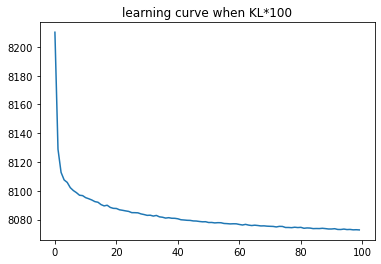

In [14]:
plt.plot(loss_record)
plt.title("learning curve when KL*100")
plt.show()

In [ ]:
# some recon_x examples(real&recon 對照)
for idx, (images, _) in enumerate(testLoader):
        # images = images/255. # normalize
        recon_images, mu, logvar = vae(images)



In [ ]:
'''
fc version
'''

In [146]:
# fc VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # self.fc1 = nn.Linear(64*64*3, 400)
        # self.fc2_1 = nn.Linear(400,20)
        # self.fc2_2 = nn.Linear(400,20)
        # self.fc3 = nn.Linear(20,400)
        # self.fc4 = nn.Linear(400,64*64*3)
        self.fc1 = nn.Linear(64*64*3, 1000)
        self.fc2_1 = nn.Linear(1000,50)
        self.fc2_2 = nn.Linear(1000,50)
        self.fc3 = nn.Linear(50,1000)
        self.fc4 = nn.Linear(1000,64*64*3)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2_1(h1), self.fc2_2(h1) # mu and var
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 64*64*3))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    # Reconstruction + KL divergence losses summed over all elements and batch
def loss_func(recon_x, x, mu, logvar):
    bce_loss = F.binary_cross_entropy(recon_x, x.view(-1, 64*64*3), reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce_loss+kl_divergence
vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

from torchvision import models
from torchsummary import summary

summary(vae, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1000]      12,289,000
            Linear-2                   [-1, 50]          50,050
            Linear-3                   [-1, 50]          50,050
            Linear-4                 [-1, 1000]          51,000
            Linear-5                [-1, 12288]      12,300,288
Total params: 24,740,388
Trainable params: 24,740,388
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.11
Params size (MB): 94.38
Estimated Total Size (MB): 94.53
----------------------------------------------------------------


In [34]:
# 2 fc
def train(epoch):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_func(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        # if batch_idx % save_interval == 0:
        #      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader),
        #         loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
def test(epoch):
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


In [83]:
# from torchvision import models
# from torchsummary import summary

# # vgg = models.vgg16()
# summary(vae, (3, 64, 64))

In [82]:
# for epoch in range(1, epochs + 1):
#     train(epoch)

In [55]:
# # 1 cnn
# for epoch in range(epochs):
#     # vae.train()
#     epoch_loss = 0
#     for batch_idx, (data, _) in enumerate(train_loader, 0):
#         #train network
#         data = Variable(data)
#         print(data.shape)
#         optimizer.zero_grad()
#         recon_x, mu, logvar = vae.forward(data)
#         loss = loss_func(recon_x, data, mu, logvar)
#         loss.backward()
#         total_loss += loss#.data[0]
#         optimizer.step()

#         if batch_idx % log_interval == 0:
#             sample = Variable(torch.randn(64, latent_code))
#             sample = vae.decoder(vae.fc2(sample).view(64, 128, 7, 7))
#             save_image(sample.data.view(64, 1, 28, 28),'./result/mysample_' + str(epoch) + '.png')
#             print('Train Epoch:{} -- [{}/{} ({:.0f}%)] -- Loss:{:.6f}'.format(epoch, i*len(data), len(train_loader.dataset), 100.*i/len(train_loader), loss/len(data)))
#             print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, total_loss / len(train_loader.dataset)))



In [124]:
# '''
# 試著印出圖片
# 並確認圖片大小
# '''
# from matplotlib.pyplot import imshow
# import numpy as np
# from PIL import Image
# import glob

# # %matplotlib inline

# image_list = []
# image_size = []
# for filename in glob.glob('../anime-faces/data/*.png'):
#     img = Image.open(filename)
#     image_list.append(img)
#     image_size.append(img.size)
#     img.load()
# # img = Image.open('../anime-faces/data/1.png', 'r')
# # imshow(np.asarray(img))
# # print(img.size)
# def unique(list1):
#     unique_list = []
#     for x in list1:
#         if x not in unique_list: 
#             unique_list.append(x)
#     for x in unique_list: 
#         print(x)
# unique(image_size) # size 皆是 64*64

(64, 64)
